# Experiment 029

In this experiment, we will selectively record gameplay data by only saving examples where the real next frame was deemed especially real by the discriminator, or where the fake next frame was deemed especially fake. Assuming this data would be added to the dataset used to originally train the model, we will check whether it has a high enough ratio of block spawns to falls.

## Record data

We will collect the data with a custom game engine.

In [1]:
import numpy as np
import numpy.typing as npt
import torch
import torch.nn.functional as F

import engines
import recording
import models

class SelectiveRecordingEngine(engines.TetrisEngine):
    fake_threshold = 0.1
    real_threshold = 0.9

    def __init__(self, engine: engines.TetrisEngine, folder: str):
        self.engine = engine
        self.db = recording.RecordingDatabase(folder)
        self.board_1 = None
        self.board_2 = None
        self.gen = models.TetrisModel()
        self.gen.load_state_dict(torch.load("tetris_emulator.pth"))
        self.gen.eval()
        self.disc = models.TetrisDiscriminator()
        self.disc.load_state_dict(torch.load("tetris_discriminator.pth"))
        self.disc.eval()

    def reset(self) -> tuple[npt.NDArray[np.int32], bool]:
        self.board_1 = None
        board, gameover = self.engine.reset()
        self.board_2 = board
        return board, gameover

    def step(self, event_type: int) -> tuple[npt.NDArray[np.int32], bool]:
        board, gameover = self.engine.step(event_type)
        self.board_1 = self.board_2
        self.board_2 = board
        self._maybe_add_example()
        return board, gameover
    
    def _maybe_add_example(self):
        x = self._transform_board(self.board_1).unsqueeze(0)
        y = self._transform_board(self.board_2).unsqueeze(0)
        with torch.no_grad():
            score_real = torch.sigmoid(self.disc(x, y)).squeeze(0).item()
        if score_real >= self.real_threshold:
            self._add_example()
            return
        y_fake = self.gen(x)
        with torch.no_grad():
            score_fake = torch.sigmoid(self.disc(x, y_fake)).squeeze(0).item()
        if score_fake <= self.fake_threshold:
            self._add_example()
    
    def _transform_board(self, board):
        board = torch.tensor(board, dtype=torch.long)
        board = F.one_hot(board, 2) # One-hot encode the cell types
        board = board.type(torch.float) # Convert to floating-point
        board = board.permute((2, 0, 1)) # Move channels/classes to dimension 0
        return board
    
    def _add_example(self):
        self.db.insert(np.array([self.board_1, self.board_2]))


In [3]:
import tetris

ROWS = 22
COLS = 10

engine: engines.TetrisEngine = engines.RuleBasedTetrisEngine(COLS, ROWS)
engine = SelectiveRecordingEngine(engine, "recordings")

app = tetris.TetrisApp(engine)
app.run()

KeyboardInterrupt: 

# Analyse data

Let's see what the collected data looks like.

In [2]:
dataset = recording.RecordingDatabase("recordings")
print(f"Dataset has {len(dataset)} examples.")

Dataset has 111 examples.


In [3]:
import matplotlib.pyplot as plt

def show_example(boards):
    fig, axs = plt.subplots(1, len(boards))
    fig.suptitle("Training example")

    for i, ax in enumerate(axs):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(f"Step {i}")
        ax.imshow(boards[i])

    plt.show()

Showing example 58


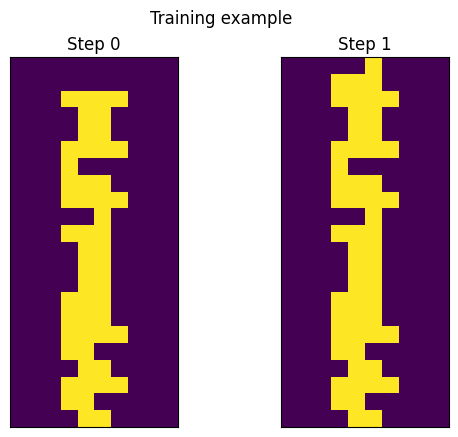

In [4]:
# Show a random example from the training set. Run this repeatedly to get an overview of the data.
import random

idx = random.randrange(len(dataset))
print(f"Showing example {idx}")
boards = dataset[idx]
show_example(boards)

Most of the examples seem to be block spawns, which is good, since that's what was lacking in the original dataset. Let's calculate exactly how many are block spawns.

In [5]:
from metrics import get_block_spawn_type

num_spawns = 0

for boards in dataset:
    boards = torch.from_numpy(boards)
    x, y = boards
    if get_block_spawn_type(x, y) is not None:
        num_spawns += 1

print(f"{num_spawns} / {len(dataset)} examples were spawns ({num_spawns / len(dataset):.2%})")

97 / 111 examples were spawns (87.39%)


Indeed, most of the examples are block spawns.

# Conclusion

When we selectively collect data according to the discriminator scores, we get a high proportion of block spawns. This way, we can avoid collecting a lot of data only to throw away most of it: we collect only what we need.

One caveat is that the data we collect will be targeted towards a particular generator's weaknesses. So, this new data should supplement an already-existing dataset instead of being used on its own. For example, the `tetris_emulator` dataset currently has 2222 examples, so we could add 200 examples collected with the selective method to form a more balanced dataset of 2422 examples. A GAN trained on this new dataset would hopefully have fewer weaknesses, and this new set of weaknesses would be the basis of the next round of data collection.